# Cuaderno 1: Análisis Exploratorio de Datos (EDA) y Extracción de Características

**Objetivo:** Cargar el dataset de sonidos respiratorios, visualizar las señales y sus representaciones espectrales, y extraer un conjunto inicial de características acústicas para el modelo baseline.

**Dataset:** [Respiratory Sound Database](https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database) de Kaggle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
import logging
import sys
import kagglehub



# --- Descarga de Datos ---
# Usamos kagglehub para descargar el dataset de forma reproducible
logging.info("Descargando el dataset desde Kaggle Hub...")
dataset_path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")
DATASET_ROOT_PATH = Path(dataset_path)
logging.info(f"Dataset descargado en: {DATASET_ROOT_PATH}")

d:\Proyectos\proyecto_cero\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Configuración ---
# Añadir src al path para poder importar nuestros módulos
sys.path.append('../src')
from data_loader import build_metadata_df, load_audio_segment, bandpass_filter, normalize_signal
from feature_extractor import extract_mfcc, extract_zcr, extract_rms_energy

# Estilo de plots y logging
sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# Celda de prueba para verificar la importación
build_metadata_df

<function data_loader.build_metadata_df(dataset_path: pathlib._local.Path) -> pandas.core.frame.DataFrame>

## 1. Construcción de Metadatos

Usamos nuestra función modular de `src/data_loader.py` para leer toda la estructura del dataset y consolidarla en un único DataFrame. Esta es la fuente de verdad para el resto del proyecto.

In [4]:
# Construir el DataFrame de metadatos
metadata_df = build_metadata_df(DATASET_ROOT_PATH)

# Inspeccionar el resultado
logging.info("Información del DataFrame de metadatos:")
metadata_df.info()

logging.info("\nPrimeras 5 filas:")
display(metadata_df.head())

logging.info("\nDistribución de diagnósticos:")
display(metadata_df.groupby('diagnosis')['patient_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start_time      6898 non-null   float64
 1   end_time        6898 non-null   float64
 2   crackles        6898 non-null   int64  
 3   wheezes         6898 non-null   int64  
 4   patient_id      6898 non-null   int64  
 5   audio_filename  6898 non-null   object 
 6   audio_path      6898 non-null   object 
 7   diagnosis       6898 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 431.3+ KB


,start_time,end_time,crackles,wheezes,patient_id,audio_filename,audio_path,diagnosis
0,0.036,0.579,0,0,101,101_1b1_Al_sc_Meditron.wav,C:\Users\Gabriel\.cache\kagglehub\datasets\vbo...,URTI
1,0.579,2.450,0,0,101,101_1b1_Al_sc_Meditron.wav,C:\Users\Gabriel\.cache\kagglehub\datasets\vbo...,URTI
2,2.450,3.893,0,0,101,101_1b1_Al_sc_Meditron.wav,C:\Users\Gabriel\.cache\kagglehub\datasets\vbo...,URTI
3,3.893,5.793,0,0,101,101_1b1_Al_sc_Meditron.wav,C:\Users\Gabriel\.cache\kagglehub\datasets\vbo...,URTI
4,5.793,7.521,0,0,101,101_1b1_Al_sc_Meditron.wav,C:\Users\Gabriel\.cache\kagglehub\datasets\vbo...,URTI


diagnosis
Asthma             1
Bronchiectasis     7
Bronchiolitis      6
COPD              64
Healthy           26
LRTI               2
Pneumonia          6
URTI              14
Name: patient_id, dtype: int64

## 2. Análisis Exploratorio de Datos (EDA)

Visualicemos las señales para entender sus diferencias. Comparamos un sonido respiratorio de un paciente sano vs. uno con EPOC.

### 2.1. Visualización de la Forma de Onda (Waveform)

La forma de onda nos muestra la amplitud de la señal a lo largo del tiempo.

In [7]:
# Seleccionar ejemplos
wheeze_example = metadata_df[metadata_df['wheezes'] == 1].iloc[1]
crackle_example = metadata_df[metadata_df['crackles'] == 1].iloc[1]
healthy_example = metadata_df[(metadata_df['crackles'] == 0) & (metadata_df['wheezes'] == 0)].iloc[1]

# Cargar los segmentos de audio
signal_w, sr_w = load_audio_segment(wheeze_example['audio_path'], wheeze_example['start_time'], wheeze_example['end_time'])
signal_c, sr_c = load_audio_segment(crackle_example['audio_path'], crackle_example['start_time'], crackle_example['end_time'])
signal_h, sr_h = load_audio_segment(healthy_example['audio_path'], healthy_example['start_time'], healthy_example['end_time'])

from IPython.display import Audio

logging.info("Escucha los ejemplos:")
display(Audio(data=signal_w, rate=sr_w))
display(Audio(data=signal_c, rate=sr_c))
display(Audio(data=signal_h, rate=sr_h))

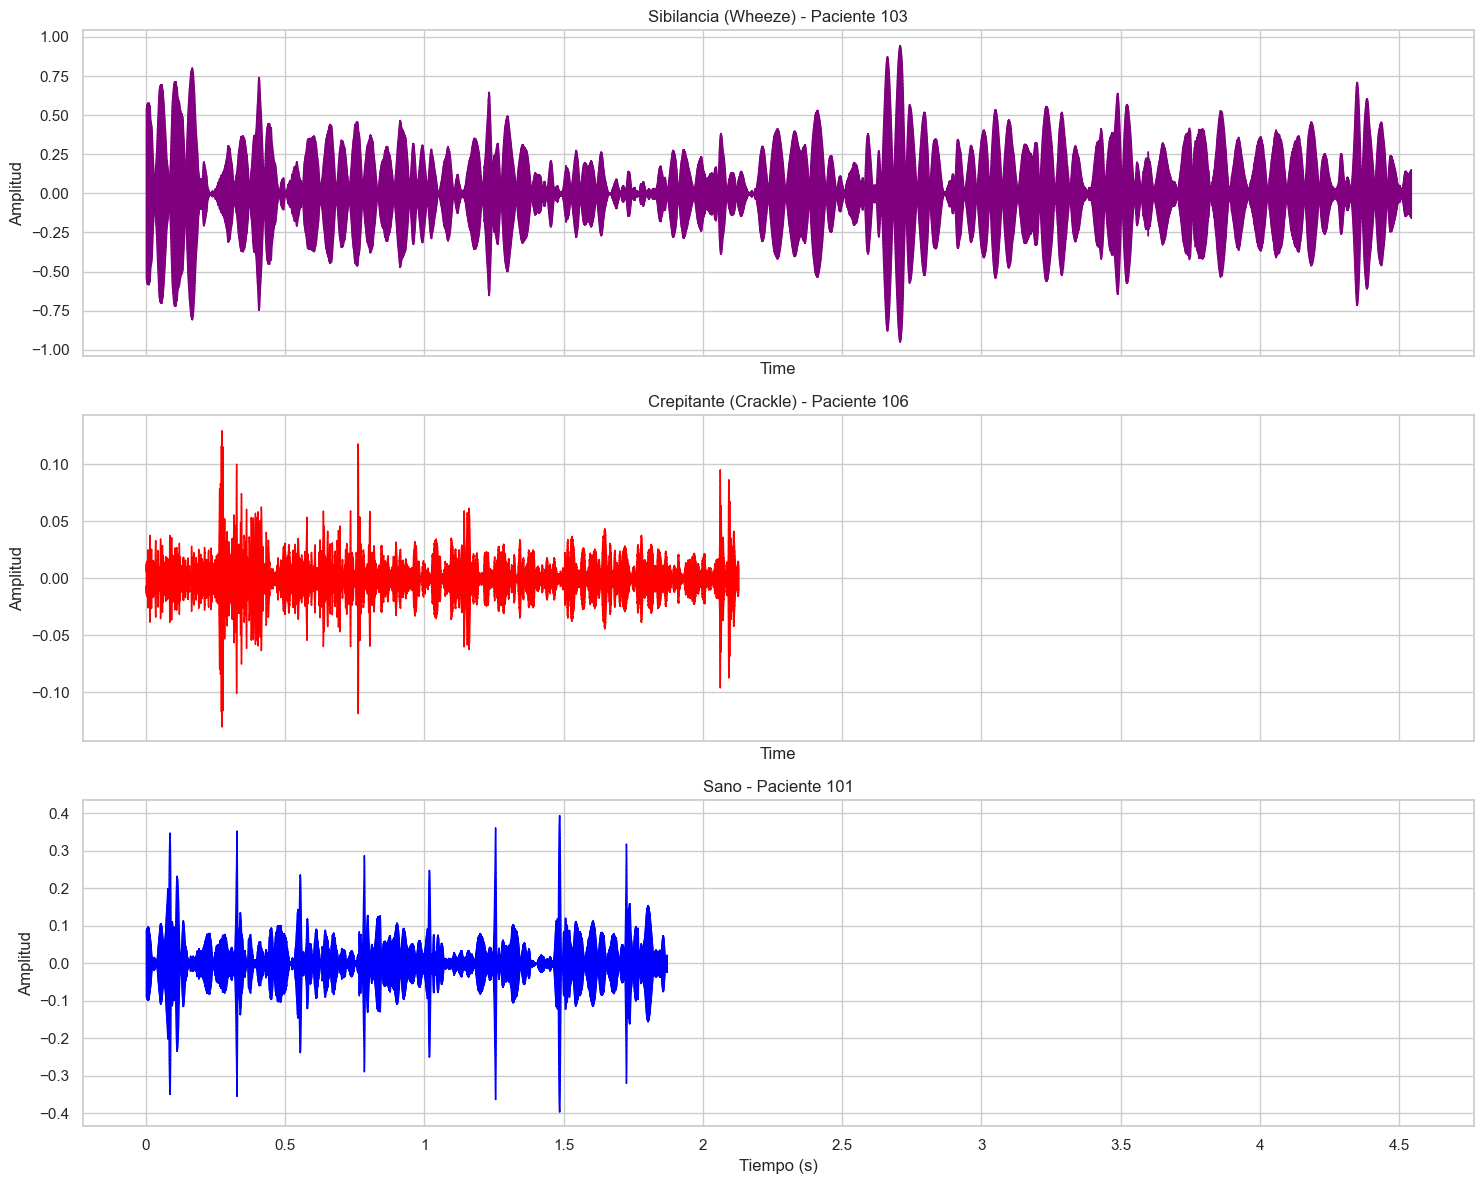

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

librosa.display.waveshow(signal_w, sr=sr_w, ax=ax[0], color='purple')
ax[0].set_title(f"Sibilancia (Wheeze) - Paciente {wheeze_example['patient_id']}")
ax[0].set_ylabel('Amplitud')

librosa.display.waveshow(signal_c, sr=sr_c, ax=ax[1], color='red')
ax[1].set_title(f"Crepitante (Crackle) - Paciente {crackle_example['patient_id']}")
ax[1].set_ylabel('Amplitud')

librosa.display.waveshow(signal_h, sr=sr_h, ax=ax[2], color='blue')
ax[2].set_title(f"Sano - Paciente {healthy_example['patient_id']}")
ax[2].set_ylabel('Amplitud')
ax[2].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()


### 2.2 Visualización de Espectrograma
Aquí es donde las diferencias se vuelven más evidentes. Las sibilancias son bandas de frecuencia armónicas y los crepitantes son picos de energía de corta duración.

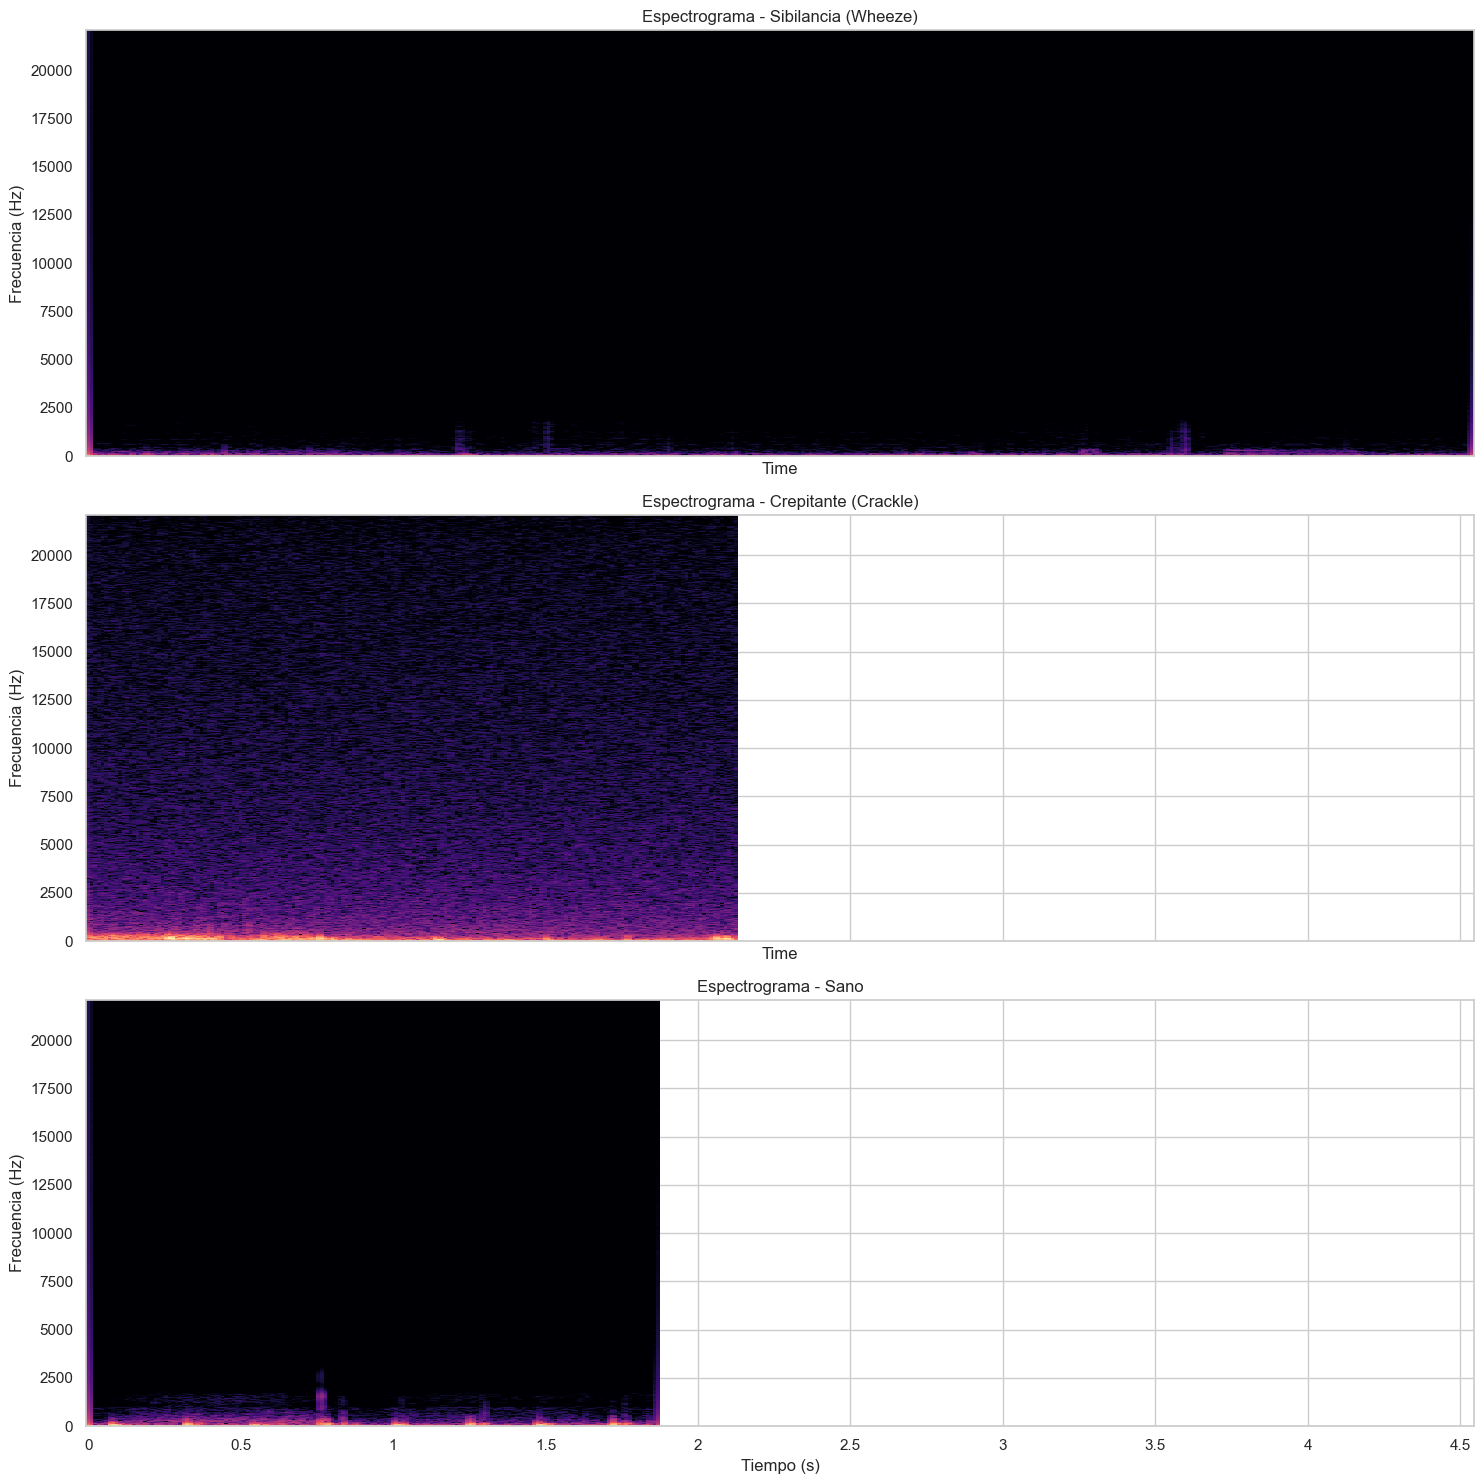

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True, sharey=True)

# Espectrograma de Sibilancia
stft_w = librosa.stft(signal_w)
db_w = librosa.amplitude_to_db(np.abs(stft_w), ref=np.max)
librosa.display.specshow(db_w, sr=sr_w, x_axis='time', y_axis='hz', ax=ax[0])
ax[0].set_title('Espectrograma - Sibilancia (Wheeze)')
ax[0].set_ylabel('Frecuencia (Hz)')

# Espectrograma de Crepitante
stft_c = librosa.stft(signal_c)
db_c = librosa.amplitude_to_db(np.abs(stft_c), ref=np.max)
librosa.display.specshow(db_c, sr=sr_c, x_axis='time', y_axis='hz', ax=ax[1])
ax[1].set_title('Espectrograma - Crepitante (Crackle)')
ax[1].set_ylabel('Frecuencia (Hz)')

# Espectrograma de Sonido Sano
stft_h = librosa.stft(signal_h)
db_h = librosa.amplitude_to_db(np.abs(stft_h), ref=np.max)
librosa.display.specshow(db_h, sr=sr_h, x_axis='time', y_axis='hz', ax=ax[2])
ax[2].set_title('Espectrograma - Sano')
ax[2].set_ylabel('Frecuencia (Hz)')
ax[2].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()